# Importation des bibliothèques

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, TensorDataset

# Partie I : Conception et évaluation d’un CNN simple et modèle hybride avec ResNet50 pré-entraîné sur CIFAR-10

## 1) Définition et entraînement d’un modèle CNN simple (avec 32, 64, 128 filtres) en utilisant Tensorflow

### Chargement du dataset CIFAR-10

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
print(f"Nombre d'images d'entraînement : {x_train.shape[0]}")
print(f"Taille d'une image : {x_train.shape[1:]}")
print(f"Nombre de classes : {len(set(y_train.flatten()))}")
print(f"Nombre d'images de test : {x_test.shape[0]}")
print(f"Nombre de classes : {len(set(y_test.flatten()))}")

Nombre d'images d'entraînement : 50000
Taille d'une image : (32, 32, 3)
Nombre de classes : 10
Nombre d'images de test : 10000
Nombre de classes : 10


### Normalisation

Afin d’améliorer la stabilité et la rapidité de l’apprentissage, les valeurs de pixels initialement comprises entre 0 et 255 ont été normalisées dans l’intervalle [0, 1].
Cette étape évite les grands écarts de valeurs et facilite la convergence du réseau de neurones.

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

In [ ]:
print("Valeurs min/max des pixels après normalisation :", x_train.min(), "/", x_train.max())

Valeurs min/max des pixels après normalisation : 0.0 / 1.0


### Encodage One-Hot des étiquettes

Les étiquettes des images (initialement des entiers de 0 à 9) ont été transformées en vecteurs binaires appelés one-hot vectors.
Cette représentation est nécessaire pour la couche de sortie du modèle utilisant la fonction d’activation softmax et la perte categorical_crossentropy.

In [ ]:
y_train[0]

array([6], dtype=uint8)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

### Séparation entraînement/validation

In [ ]:
VAL_SPLIT = 0.2
n = x_train.shape[0]
n_val = int(n * VAL_SPLIT)

x_val, y_val = x_train[:n_val], y_train[:n_val]
x_train, y_train = x_train[n_val:], y_train[n_val:]

In [ ]:
print(f"Train : {x_train.shape}, validation : {x_val.shape}, test : {x_test.shape}")


Train : (40000, 32, 32, 3), validation : (10000, 32, 32, 3), test : (10000, 32, 32, 3)


### Visualisation de quelques images du dataset

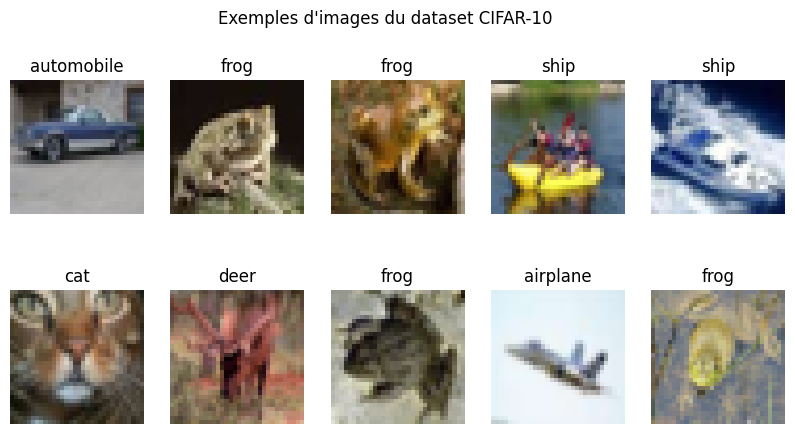

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[np.argmax(y_train[i])])
    plt.axis('off')
plt.suptitle("Exemples d'images du dataset CIFAR-10")
plt.show()

### Définition du modèle

In [ ]:
def model_cnn(num_filters1=32, num_filters2=64, num_filters3=128, num_classes=10):
    model = models.Sequential([
        layers.Conv2D(num_filters1, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(num_filters2, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(num_filters3, (3,3), activation='relu', padding='same'),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


### Fonction d’entraînement et d’évaluation

**EarlyStopping :** arrête l’entraînement si la val_accuracy ne s’améliore pas pendant 3 epochs et restaure les meilleurs poids.

**ReduceLROnPlateau :** réduit le taux d’apprentissage de moitié si la val_loss stagne pendant 2 epochs, jusqu’à un minimum de 1e−5

In [ ]:
def train_and_evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, epochs=50, batch_size=64):
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1),

        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)
    ]

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    start_train = time.time()
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=callbacks, verbose=1)
    training_time = time.time() - start_train

    start_test = time.time()
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    test_time = time.time() - start_test

    print(f"\n\nTest accuracy : {test_acc:.4f}, test loss : {test_loss:.4f}")
    print(f"Temps d'entraînement : {training_time:.2f} secondes, temps de test: {test_time:.4f} secondes")

    return history, training_time, test_time, test_acc



### Courbes de perte et d’accuracy

In [ ]:
def plot_courbes(history, title="Courbes d'apprentissage"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    plt.suptitle(title)
    plt.show()


### Métriques : Précision, Rappel, F1 et Matrice de confusion

In [ ]:
def metriques(model, x_test, y_test, class_names):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\nRapport de classification :\n")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Matrice de confusion")
    plt.ylabel('Vraies classes')
    plt.xlabel('Prédictions')
    plt.show()


### Entraînement et Résultat

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,242 (4.36 MB)

 Trainable params: 1,143,242 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2881 - loss: 1.9068 - val_accuracy: 0.5406 - val_loss: 1.2993 - learning_rate: 0.0010
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5080 - loss: 1.3826 - val_accuracy: 0.6309 - val_loss: 1.0699 - learning_rate: 0.0010
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5894 - loss: 1.1679 - val_accuracy: 0.6646 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6317 - loss: 1.0499 - val_accuracy: 0.6922 - val_loss: 0.8774 - learning_rate: 0.0010
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6678 - loss: 0.9425 - val_accuracy: 0.7006 - val_loss: 0.8391 - learning_rate: 0.0010
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6978 - loss: 0.8756 - val_accuracy: 0.6991 - val_loss: 0.8712 - learning_rate: 0.0010
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7211 - loss: 0.7875 - 

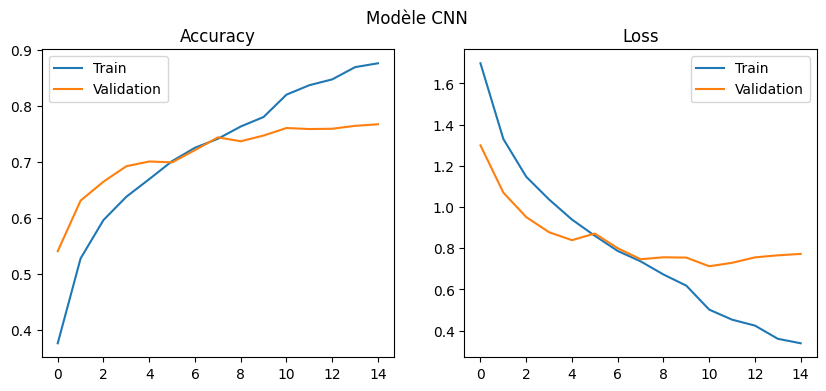

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Rapport de classification :

              precision    recall  f1-score   support

    airplane       0.80      0.81      0.80      1000
  automobile       0.88      0.86      0.87      1000
        bird       0.69      0.67      0.68      1000
         cat       0.58      0.57      0.58      1000
        deer       0.72      0.74      0.73      1000
         dog       0.62      0.69      0.65      1000
        frog       0.86      0.80      0.83      1000
       horse       0.78      0.81      0.80      1000
        ship       0.88      0.85      0.86      1000
       truck       0.85      0.82      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



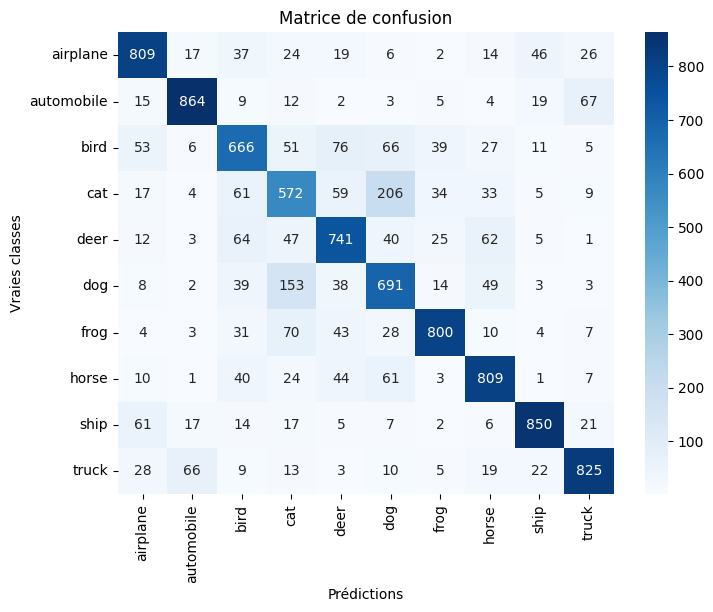

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

model = model_cnn()
model.summary()

history, train_time, test_time, test_acc = train_and_evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, epochs=15)

plot_courbes(history, f"Modèle CNN")

metriques(model, x_test, y_test, class_names)

In [ ]:
params = model.count_params()
print(f"\nNombre de paramètres du modèle : {params}")


Nombre de paramètres du modèle : 1143242


### 1. Courbes d’Apprentissage

* **Train accuracy** : monte régulièrement jusqu’à 88%.  
* **Validation accuracy** : plafonne à 76% dès la 9eme époque.

* **Train loss** : continue de baisser.  
* **validation loss** remonte après la 11eme époque.

**Interprétation** : Le modèle apprend trop bien les données d’entraînement et généralise mal sur les nouvelles données : **le surapprentissage**.

### 2. Matrice de Confusion

* **Bonnes classes :** automobile, ship, truck, frog, airplane, horse (F1 > 0.8).
* **Classes difficiles :** cat et dog souvent confondues entre elles.  
Car Ces deux classes partagent des traits visuels similaires, d’où des erreurs fréquentes. Les véhicules sont mieux reconnus car leurs formes sont plus distinctes.

### 3. Rapport de Classification

* **Accuracy globale :** 0.76
* **Classes fortes :** automobile, ship, truck
* **Classes faibles :** cat (F1=0.58), dog (F1=0.65)


## 2) Création des modèles avec ResNet50 en utilisant Pytorch

### Redimensionnement et normalisation des données d’image

In [3]:
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Chargement les datasets avec transformations

In [4]:
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


### Séparation entraînement/validation

In [5]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


### Création des DataLoaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


**ResNet50 :** C’est un réseau convolutionnel profond de 50 couches utilisant des blocs résiduels (residual blocks). Chaque bloc inclut des connexions de contournement (skip connections) qui permettent au gradient de circuler directement à travers le réseau, réduisant le problème de vanishing gradient et facilitant l’entraînement de très grands modèles. Cette architecture permet d’atteindre une forte capacité de représentation tout en maintenant une convergence stable, ce qui en fait un choix populaire pour le transfer learning et les tâches de vision par ordinateur sur des datasets complexes.

### Architecture 1 : Combinaison de ResNet50 pré-entraîné avec un CNN simple
ResNet50 non gelé.

#### Définition du modèle

In [ ]:
class CNN_ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_ResNet50, self).__init__()

        # Petit CNN avant ResNet
        self.custom_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Adapter la première couche
        self.resnet.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Garder la tête FC d'origine
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.custom_cnn(x)
        x = self.resnet(x)
        return x

#### Initialisation du modèle et optimiseur

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_ResNet50(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#### Entraînement du modèle

In [ ]:
num_epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_train = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Époque [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

end_train = time.time()
train_time = end_train - start_train
print(f"\nTemps total d'entraînement : {train_time:.2f} secondes")

Époque [1/3], train loss: 1.2306, train_acc: 0.5720, val loss: 0.9729, val_acc: 0.7177
Époque [2/3], train loss: 0.6346, train_acc: 0.7811, val loss: 0.4774, val_acc: 0.8401
Époque [3/3], train loss: 0.4531, train_acc: 0.8448, val loss: 0.4672, val_acc: 0.8401

Temps total d'entraînement : 975.84 secondes


#### Évaluation sur test

In [ ]:
start_test = time.time()
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= total_test
test_acc = correct_test / total_test
end_test = time.time()

print(f"\nTest accuracy: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps d'évaluation test : {end_test - start_test:.2f} secondes")


Test accuracy: 0.8363, test loss: 0.4790
Temps d'évaluation test : 32.70 secondes


#### Courbes d'entraînement et de perte

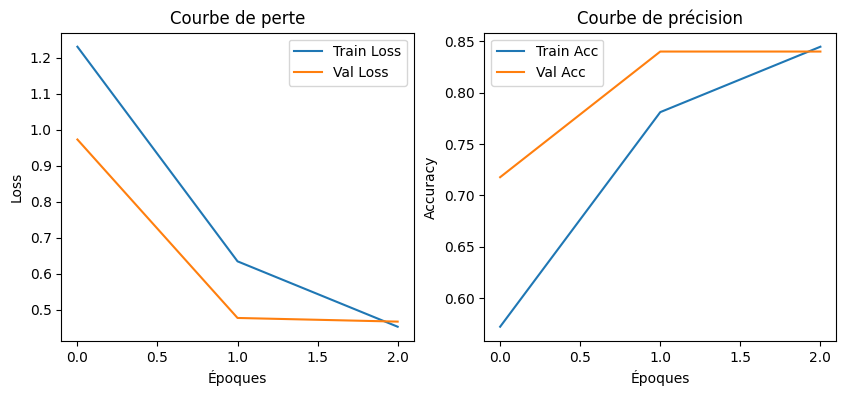

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Courbe de perte")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Courbe de précision")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



#### Matrice de confusion et rapport de classification

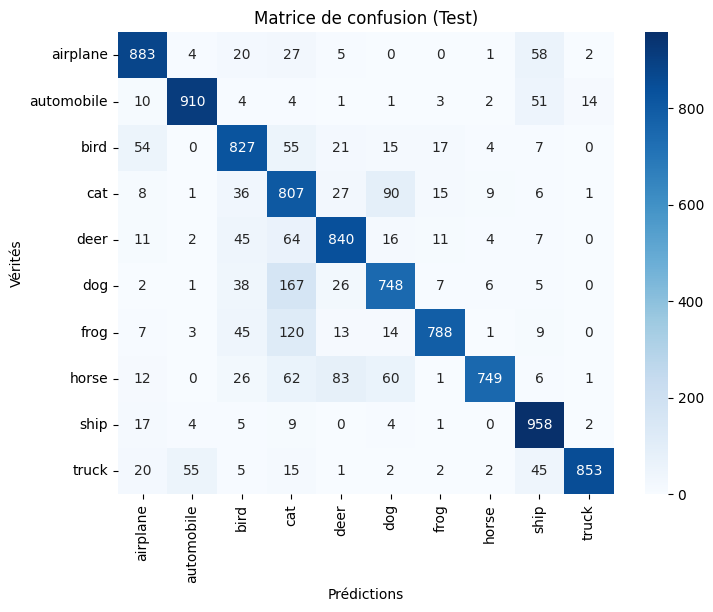


Rapport de classification :

              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.93      0.91      0.92      1000
        bird       0.79      0.83      0.81      1000
         cat       0.61      0.81      0.69      1000
        deer       0.83      0.84      0.83      1000
         dog       0.79      0.75      0.77      1000
        frog       0.93      0.79      0.85      1000
       horse       0.96      0.75      0.84      1000
        ship       0.83      0.96      0.89      1000
       truck       0.98      0.85      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.title("Matrice de confusion (Test)")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

print("\nRapport de classification :\n")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))


### Architecture 2 : Ajouter des couches de CNN personnalisées
ResNet50 non gelé.

#### Définition du modèle


In [ ]:
class CNNResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNResNet50, self).__init__()

        # Blocs CNN personnalisés
        self.custom_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # Ajustemert des canaux d'entrée
        self.resnet.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.custom_cnn(x)
        x = self.resnet(x)
        return x


#### Initialisation du modèle et optimiseur

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNResNet50(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#### Entraînement du modèle

In [ ]:
num_epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"\nTemps total d'entraînement : {training_time:.2f} secondes")


Epoch [1/3], train loss: 1.1096, train_acc: 0.6156, val loss: 0.6445, val_acc: 0.7814
Epoch [2/3], train loss: 0.5866, train_acc: 0.8049, val loss: 0.4837, val_acc: 0.8356
Epoch [3/3], train loss: 0.3993, train_acc: 0.8686, val loss: 0.4303, val_acc: 0.8544

Temps total d'entraînement : 761.80 secondes


#### Évaluation sur test

In [ ]:
start_test = time.time()
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= total_test
test_acc = correct_test / total_test
end_test = time.time()

print(f"\nTest accuracy: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps d'évaluation test : {end_test - start_test:.2f} secondes")


Test accuracy: 0.8513, test loss: 0.4518
Temps d'évaluation test : 24.96 secondes


#### Courbes d'entraînement et de perte

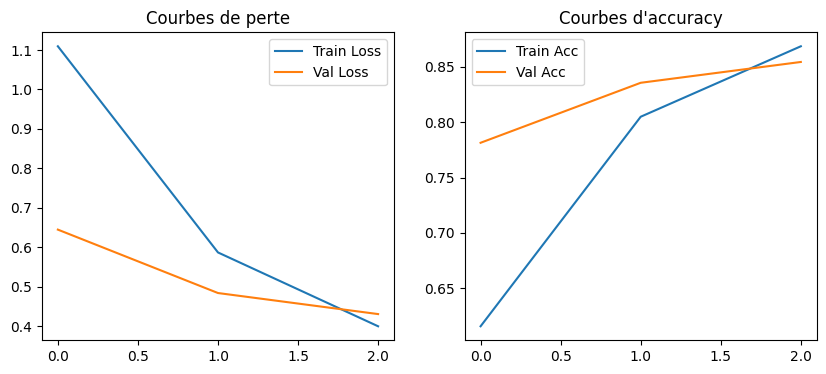

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Courbes de perte")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Courbes d'accuracy")
plt.show()

#### Matrice de confusion et rapport de classification

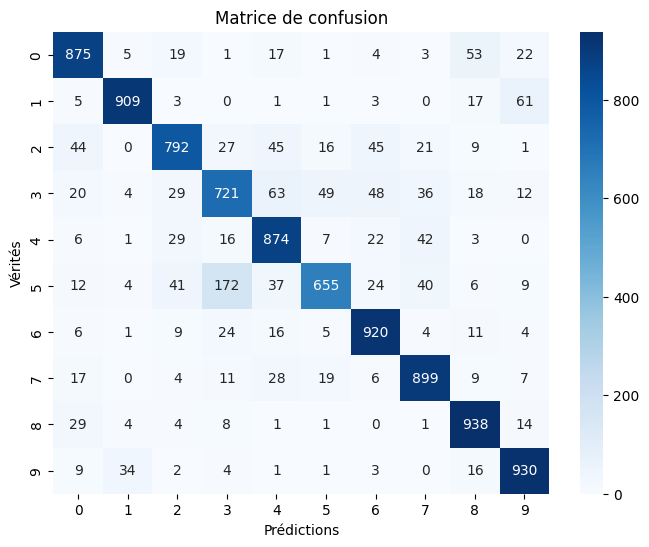


Rapport de classification :

              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.94      0.91      0.93      1000
        bird       0.85      0.79      0.82      1000
         cat       0.73      0.72      0.73      1000
        deer       0.81      0.87      0.84      1000
         dog       0.87      0.66      0.75      1000
        frog       0.86      0.92      0.89      1000
       horse       0.86      0.90      0.88      1000
        ship       0.87      0.94      0.90      1000
       truck       0.88      0.93      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

print("\nRapport de classification :\n")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))


### Architecture 3 : CNN personnalisées
ResNet50 gelé.

#### Définition du modèle

In [ ]:
class CNNResNet50Frozen(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNResNet50Frozen, self).__init__()

        # CNN personnalisé
        self.custom_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Géler tous les paramètres de ResNet50
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Nouvelle tête FC
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.custom_cnn(x)
        x = self.resnet(x)
        return x

#### Initialisation du modèle et optimiseur

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNResNet50Frozen(num_classes=10).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

CNNResNet50Frozen(
  (custom_cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (resnet): ResNet(
    (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1)

#### Entraînement du modèle

In [ ]:
num_epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"\nTemps total d'entraînement : {training_time:.2f} secondes")


Epoch [1/3], train loss: 2.1003, train_acc: 0.2144, val loss: 2.0119, val_acc: 0.2536
Epoch [2/3], train loss: 2.0738, train_acc: 0.2242, val loss: 1.9746, val_acc: 0.2561
Epoch [3/3], train loss: 2.0351, train_acc: 0.2468, val loss: 1.9822, val_acc: 0.2708

Temps total d'entraînement : 666.86 secondes


#### Évaluation sur test

In [ ]:
start_test = time.time()
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= total_test
test_acc = correct_test / total_test
end_test = time.time()

print(f"\nTest accuracy: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps d'évaluation test : {end_test - start_test:.2f} secondes")


Test accuracy: 0.2876, test loss: 1.9440
Temps d'évaluation test : 26.30 secondes


#### Courbes d'entraînement et de perte

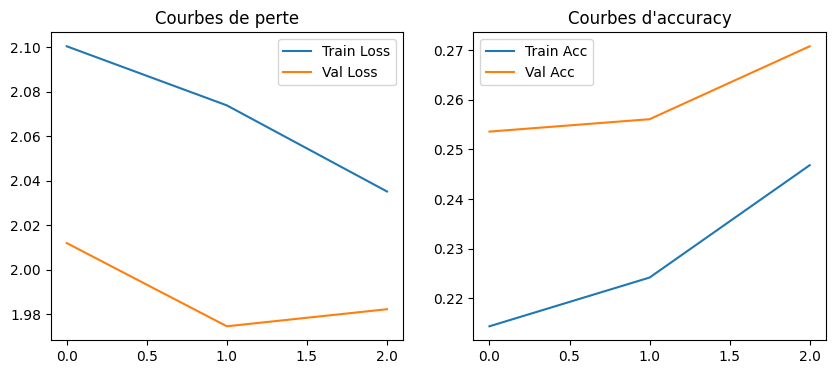

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Courbes de perte")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Courbes d'accuracy")
plt.show()

#### Matrice de confusion et rapport de classification

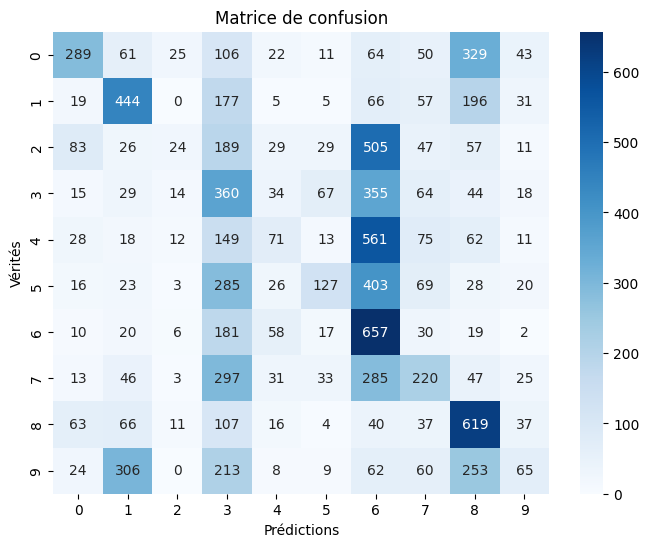


Rapport de classification :

              precision    recall  f1-score   support

    airplane       0.52      0.29      0.37      1000
  automobile       0.43      0.44      0.44      1000
        bird       0.24      0.02      0.04      1000
         cat       0.17      0.36      0.23      1000
        deer       0.24      0.07      0.11      1000
         dog       0.40      0.13      0.19      1000
        frog       0.22      0.66      0.33      1000
       horse       0.31      0.22      0.26      1000
        ship       0.37      0.62      0.47      1000
       truck       0.25      0.07      0.10      1000

    accuracy                           0.29     10000
   macro avg       0.32      0.29      0.25     10000
weighted avg       0.32      0.29      0.25     10000



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

print("\nRapport de classification :\n")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))


### Architecture 4 : Ajout des couches de classification personnalisées
ResNet50 avec tête de classification personnalisée (couches FC supplémentaires)

#### Définition du modèle


In [ ]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

#### Initialisation du modèle et optimiseur

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomResNet50(num_classes=10).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


CustomResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

#### Entraînement du modèle

In [ ]:
num_epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"\nTemps total d'entraînement : {training_time:.2f} secondes")


Epoch [1/3], train loss: 0.8183, train_acc: 0.7305, val loss: 0.6400, val_acc: 0.7836
Epoch [2/3], train loss: 0.4741, train_acc: 0.8468, val loss: 0.4179, val_acc: 0.8714
Epoch [3/3], train loss: 0.3559, train_acc: 0.8834, val loss: 0.2918, val_acc: 0.9033

Temps total d'entraînement : 1426.56 secondes


#### Évaluation sur test

In [ ]:
start_test = time.time()
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= total_test
test_acc = correct_test / total_test
end_test = time.time()

print(f"\nTest accuracy: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps d'évaluation test : {end_test - start_test:.2f} secondes")


Test accuracy: 0.9023, test loss: 0.2938
Temps d'évaluation test : 40.41 secondes


#### Courbes d'entraînement et de perte

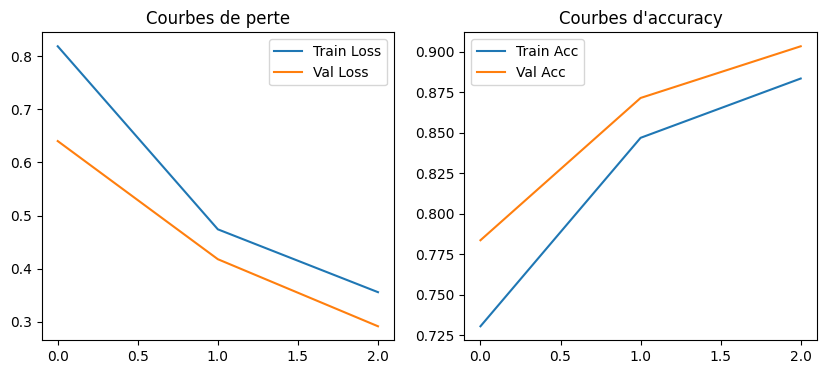

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Courbes de perte")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Courbes d'accuracy")
plt.show()

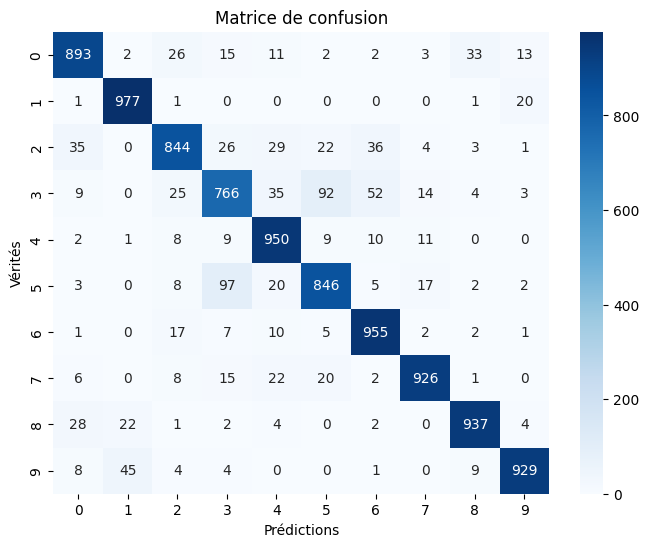


Rapport de classification :

              precision    recall  f1-score   support

    airplane       0.91      0.89      0.90      1000
  automobile       0.93      0.98      0.95      1000
        bird       0.90      0.84      0.87      1000
         cat       0.81      0.77      0.79      1000
        deer       0.88      0.95      0.91      1000
         dog       0.85      0.85      0.85      1000
        frog       0.90      0.95      0.92      1000
       horse       0.95      0.93      0.94      1000
        ship       0.94      0.94      0.94      1000
       truck       0.95      0.93      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

print("\nRapport de classification :\n")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))

### Comparaison des Architectures
| Architecture | Temps entraînement (s) | Temps test (s) | Test Accuracy | Test Loss | Precision | Recall | F1-score |
| -- | -- | -- | -- | -- | -- | -- | -- |
| CNN seule | 57.04| 3.37 | 0.7627 | 0.8152 | 0.77| 0.76 | 0.76|
| Arch 1 : CNN simple + ResNet50| 975.84| 32.70| 0.8363 | 0.4790 | 0.85| 0.84 | 0.84|
| Arch 2 : CNN personnalisées + ResNet50| 761.80| 24.96| 0.8513 | 0.4518 | 0.85| 0.85 | 0.85|
| Arch 3 : CNN personnalisées + ResNet50 gelé | 666.86| 26.30| 0.2876 | 1.9440 | 0.32| 0.29 | 0.25|
| Arch 4 : ResNet50 avec FC personnalisées | 1426.56  | 40.41| 0.9023 | 0.2938 | 0.90| 0.90 | 0.90|

* Le **CNN de base** obtient une précision correcte 76% mais reste limité dans la reconnaissance de classes complexes.
* L’intégration de **ResNet50** (préentraîné sur ImageNet) améliore significativement la performance : les architectures combinées atteignent 0.83 à 0.90 d’accuracy.
* Le **gel complet du ResNet50** (sans fine-tuning) dégrade fortement les résultats 29%, confirmant que l’adaptation des poids est essentielle.

#### Impact du fine-tuning

* Le **fine-tuning partiel** des couches du ResNet permet d’exploiter au mieux les représentations apprises tout en adaptant le modèle au dataset cible.
* Cette approche équilibre **temps d’entraînement** et **qualité de généralisation** (notamment sur Arch 2).

#### Influence de la complexité du modèle

* L’ajout de **couches CNN personnalisées** (Arch 2) améliore la qualité des features extraites tout en réduisant légèrement le temps par rapport à une ResNet brute (Arch 1).
* Les **couches fully connected (FC)** plus profondes (Arch 4) atteignent la meilleure précision 90% mais au prix d’un temps d’exécution plus élevé.


#### Conclusion

Le **transfer learning avec fine-tuning** est la clé pour obtenir de hautes performances sur des jeux d’images complexes comme **CIFAR-10 et CIFAR-100**.
La **personnalisation des couches convolutionnelles et fully connected** permet d’atteindre un meilleur équilibre entre **précision, temps et ressources**.
Ainsi :

* **CNN simple** : rapide mais limité
* **CNN + ResNet50 (fine-tuning partiel)** : meilleur compromis
* **ResNet50 + FC avancées** : meilleure performance absolue


# Partie II : Exploration d’architectures pré-entraînées avancées


### CIFAR-10

#### VGG16

**VGG16 :** C’est un réseau convolutionnel profond de type séquentiel comportant 16 couches avec poids appris sur ImageNet. Il utilise exclusivement des filtres 3×3 et des couches de pooling max 2×2 pour extraire des représentations hiérarchiques des images. Sa profondeur permet une meilleure capacité de représentation, mais l’absence de mécanismes de connectivité avancés (comme les connexions résiduelles) le rend coûteux en mémoire et sensible au vanishing gradient sur des jeux de données plus petits.

##### Définition du modèle

In [7]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(VGG16, self).__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)

        # Modification de la dernière couche fully connected
        input_features = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Linear(input_features, num_classes)

    def forward(self, x):
        return self.vgg(x)

##### Initialisation du modèle et optimiseur

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=10, pretrained=True)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 79.2MB/s]


##### Entraînement du modèle

In [9]:
num_epochs = 3

train_losses, val_losses, train_accs, val_accs = [], [], [], []

start_train = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    print(f"Époque [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")
end_train = time.time()
print(f"\nTemps total d'entraînement VGG16 : {end_train - start_train:.2f} secondes")

Époque [1/3], train loss: 1.4118, val loss: 0.9491, val acc: 0.6709
Époque [2/3], train loss: 0.8180, val loss: 0.7608, val acc: 0.7386
Époque [3/3], train loss: 0.6439, val loss: 0.5862, val acc: 0.8032

Temps total d'entraînement VGG16 : 2251.08 secondes


##### Evaluation sur test

In [10]:
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time.time()
test_duration = end_time - start_time

test_loss /= total_test
test_acc = correct_test / total_test

print(f"Test accuracy VGG16: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps de test VGG16 : {test_duration:.2f} secondes")

Test accuracy VGG16: 0.7986, test loss: 0.5983
Temps de test VGG16 : 61.66 secondes


##### Courbes d'apprentissage et de perte

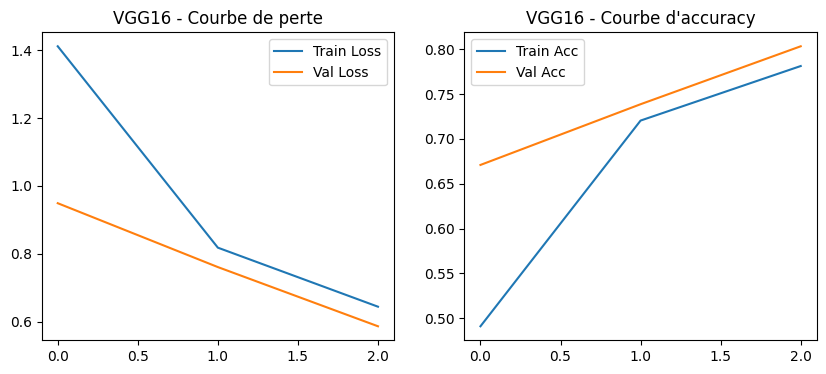

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("VGG16 - Courbe de perte")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("VGG16 - Courbe d'accuracy")
plt.legend()
plt.show()

##### Matrice de confusion et rapport de classification

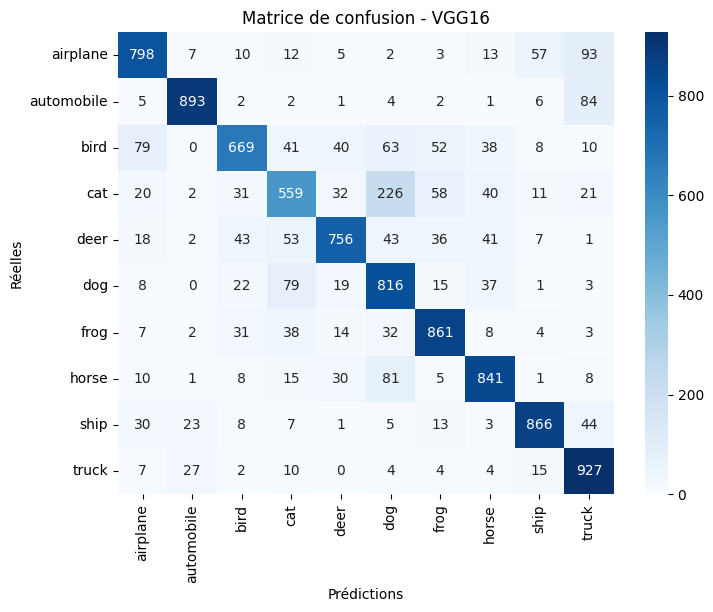


Rapport de classification VGG16:

              precision    recall  f1-score   support

    airplane       0.81      0.80      0.81      1000
  automobile       0.93      0.89      0.91      1000
        bird       0.81      0.67      0.73      1000
         cat       0.69      0.56      0.62      1000
        deer       0.84      0.76      0.80      1000
         dog       0.64      0.82      0.72      1000
        frog       0.82      0.86      0.84      1000
       horse       0.82      0.84      0.83      1000
        ship       0.89      0.87      0.88      1000
       truck       0.78      0.93      0.85      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [12]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.title("Matrice de confusion - VGG16")
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.show()

print("\nRapport de classification VGG16:\n")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))

#### DenseNet121

**DenseNet121 :** Réseau convolutionnel avec 121 couches, caractérisé par ses connexions denses. Chaque couche reçoit en entrée toutes les cartes de caractéristiques précédentes et transmet ses propres cartes à toutes les couches suivantes. Cette architecture facilite la réutilisation des features, réduit le nombre de paramètres et améliore la propagation du gradient, permettant un entraînement plus stable sur des datasets limités tout en conservant une haute performance.

##### Chargement du modèle

In [ ]:
model = models.densenet121(weights='IMAGENET1K_V1')
model.classifier = nn.Linear(model.classifier.in_features, 10)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 108MB/s] 


##### Optimiseur

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Entraînement du modèle

In [ ]:
num_epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

start_train = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    print(f"Époque [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")
end_train = time.time()
print(f"\nTemps total d'entraînement DenseNet121 : {end_train - start_train:.2f} secondes")

Époque [1/3], train loss: 0.8084, val loss: 0.6209, val acc: 0.7897
Époque [2/3], train loss: 0.5270, val loss: 0.4480, val acc: 0.8469
Époque [3/3], train loss: 0.4137, val loss: 0.3733, val acc: 0.8705

Temps total d'entraînement DenseNet121 : 1547.84 secondes


##### Evaluation sur test

In [ ]:
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time.time()
test_duration = end_time - start_time

test_loss /= total_test
test_acc = correct_test / total_test

print(f"Test accuracy DenseNet121: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps de test DenseNet121 : {test_duration:.2f} secondes")

Test accuracy DenseNet121: 0.8741, test loss: 0.3716
Temps de test DenseNet121 : 45.62 secondes


##### Courbes d'entraînement et de perte

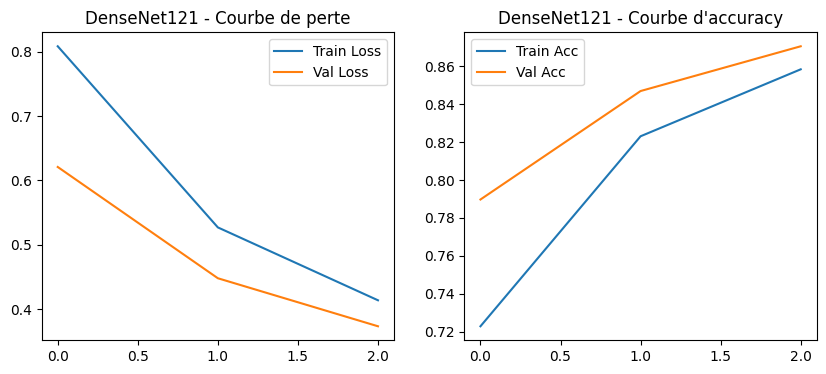

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("DenseNet121 - Courbe de perte")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("DenseNet121 - Courbe d'accuracy")
plt.legend()
plt.show()

##### Matrice de confusion et rapport de classification

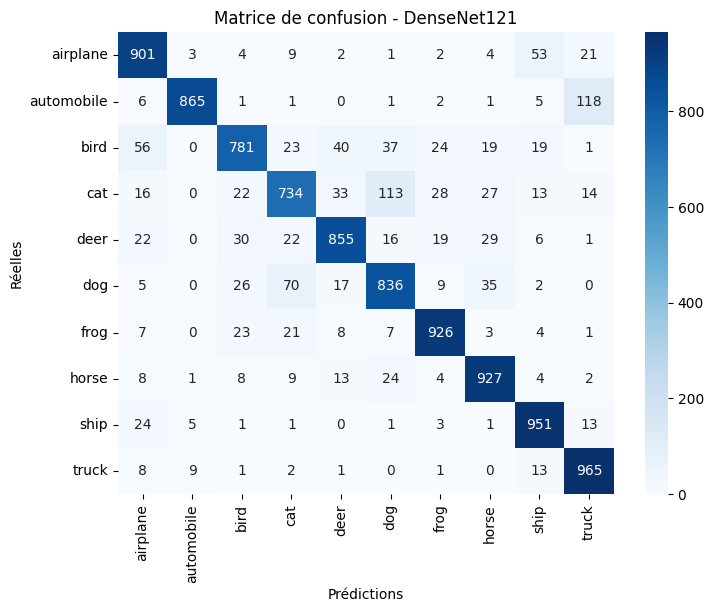


Rapport de classification DenseNet121:

              precision    recall  f1-score   support

    airplane       0.86      0.90      0.88      1000
  automobile       0.98      0.86      0.92      1000
        bird       0.87      0.78      0.82      1000
         cat       0.82      0.73      0.78      1000
        deer       0.88      0.85      0.87      1000
         dog       0.81      0.84      0.82      1000
        frog       0.91      0.93      0.92      1000
       horse       0.89      0.93      0.91      1000
        ship       0.89      0.95      0.92      1000
       truck       0.85      0.96      0.90      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.title("Matrice de confusion - DenseNet121")
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.show()

print("\nRapport de classification DenseNet121:\n")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))

#### EfficientNetB0

**EfficientNetB0 :** Modèle CNN issu de la famille EfficientNet, optimisé par la stratégie de compound scaling, qui ajuste simultanément la profondeur, la largeur et la résolution spatiale du réseau. Conçu pour maximiser la performance sur ImageNet tout en minimisant le coût computationnel, EfficientNetB0 atteint un équilibre optimal entre précision, efficacité des paramètres et temps d’inférence, faisant de lui un des modèles de référence pour le transfert learning moderne.

##### Chargement du modèle

In [ ]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)
print(model)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 59.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

##### Optimiseur

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Entraînement

In [ ]:
num_epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

start_train = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    print(f"Époque [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")
end_train = time.time()
print(f"\nTemps total d'entraînement EfficientNetB0 : {end_train - start_train:.2f} secondes")

Époque [1/3], train loss: 0.5851, val loss: 0.3643, val acc: 0.8775
Époque [2/3], train loss: 0.3718, val loss: 0.3046, val acc: 0.8961
Époque [3/3], train loss: 0.2940, val loss: 0.2794, val acc: 0.9074

Temps total d'entraînement EfficientNetB0 : 831.57 secondes


##### Evaluation sur test

In [ ]:
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time.time()
test_duration = end_time - start_time

test_loss /= total_test
test_acc = correct_test / total_test

print(f"Test accuracy EfficientNetB0: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps de test EfficientNetB0 : {test_duration:.2f} secondes")

Test accuracy EfficientNetB0: 0.9067, test loss: 0.2841
Temps de test EfficientNetB0 : 38.26 secondes


##### Courbes d'entraînement et de perte

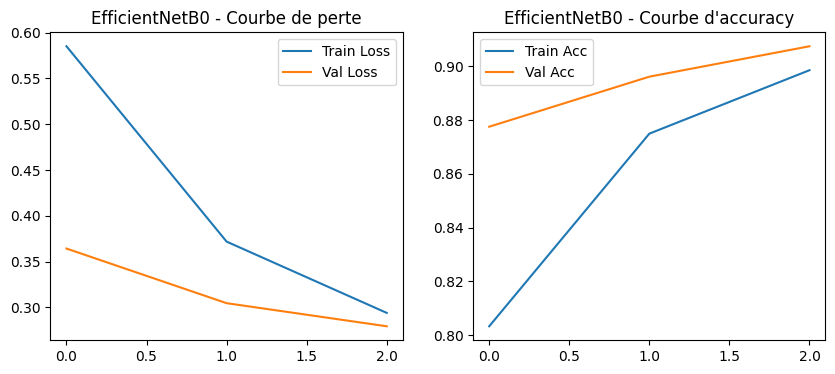

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("EfficientNetB0 - Courbe de perte")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("EfficientNetB0 - Courbe d'accuracy")
plt.legend()
plt.show()

##### Matrice de confusion et rapport de classification

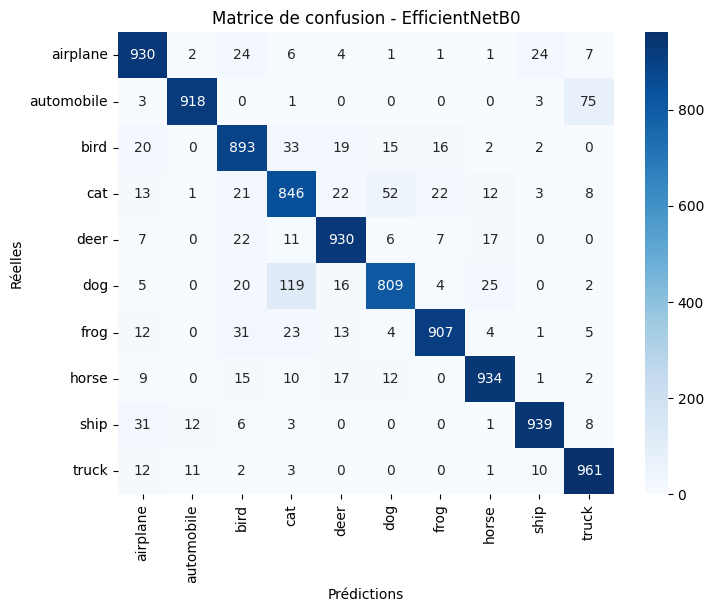


Rapport de classification EfficientNetB0:

              precision    recall  f1-score   support

    airplane       0.89      0.93      0.91      1000
  automobile       0.97      0.92      0.94      1000
        bird       0.86      0.89      0.88      1000
         cat       0.80      0.85      0.82      1000
        deer       0.91      0.93      0.92      1000
         dog       0.90      0.81      0.85      1000
        frog       0.95      0.91      0.93      1000
       horse       0.94      0.93      0.94      1000
        ship       0.96      0.94      0.95      1000
       truck       0.90      0.96      0.93      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.title("Matrice de confusion - EfficientNetB0")
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.show()

print("\nRapport de classification EfficientNetB0:\n")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))

### Comparaison des modèles CNN pré-entraînés sur CIFAR-10

| Modèle| Accuracy| Précision | Recall | Score F1 | Loss | Entraînement (s) | Test (s) |
| -- | -- | -- | -- | -- | -- | -- | -- |
| **VGG16**| 0.7986 | 0.8 | 0.8 | 0.8 | 0.5983 | 2251.08 | 61.66|
| **DenseNet121**| 0.87 | 0.88 | 0.87 | 0.87 | 0.3716 | 1547.84 | 45.62|
| **EfficientNetB0** | 0.91 | 0.91 | 0.91 | 0.91 | 0.2841 | 831.57| 38.26|

**1. Impact du transfert learning :**
Le transfert de poids pré-entraînés sur ImageNet améliore nettement les performances.
VGG16, plus ancien et lourd, montre une généralisation de **80%**.
En revanche, **DenseNet121 87%** et **EfficientNetB0 91%** profitent du transfert learning grâce à leurs architectures plus récentes et mieux normalisées.

**2. Influence de l’architecture :**

* **VGG16** : très profond, peu efficace sur petits jeux de données.
* **DenseNet121** : cses connexions denses favorisent la réutilisation des caractéristiques et la propagation du gradient.
* **EfficientNetB0** : bénéficie d’un scaling équilibré (profondeur, largeur et résolution), offrant un excellent rapport de performance.

**Conclusion :**
Les architectures récentes comme **EfficientNetB0** offrent le **meilleur compromis entre précision, rapidité et coût de calcul**.
Elles surpassent les modèles plus anciens en combinant efficacité, rapidité et capacité de généralisation.


### CIFAR-100

#### Redimensionnement et normalisation des données d’image

In [13]:
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#### Chargement les datasets avec transformations

In [14]:
full_train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

100%|██████████| 169M/169M [00:13<00:00, 12.3MB/s]


#### Séparation entraînement/validation

In [15]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#### Création des DataLoaders

In [16]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### VGG16

##### Définition du modèle

In [18]:
class VGG16(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16, self).__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        in_features = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vgg(x)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=100)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

##### Entraînement du modèle

In [21]:
num_epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_train = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Époque [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

end_train = time.time()
train_time = end_train - start_train
print(f"\nTemps total d'entraînement VGG16 : {train_time:.2f} secondes")

Époque [1/3] - Train Loss: 3.4353, Train Acc: 0.1795, Val Acc: 0.3195
Époque [2/3] - Train Loss: 2.5170, Train Acc: 0.3487, Val Acc: 0.4000
Époque [3/3] - Train Loss: 2.1645, Train Acc: 0.4241, Val Acc: 0.4239

Temps total d'entraînement VGG16 : 2264.76 secondes


##### Évaluation sur le test

In [22]:
start_test = time.time()
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= total_test
test_acc = correct_test / total_test
end_test = time.time()

print(f"\nTest accuracy VGG16: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps de test VGG16 : {end_test - start_test:.2f} secondes")


Test accuracy VGG16: 0.4318, test loss: 2.1367
Temps de test VGG16 : 68.27 secondes


##### Courbes d'entraînement  et de perte

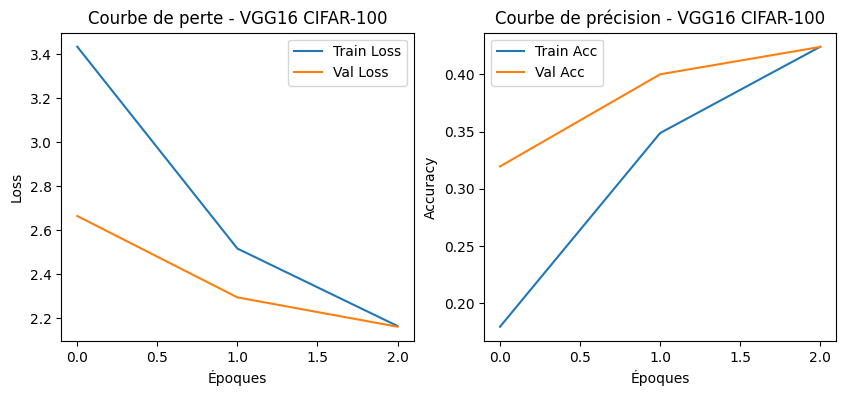

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Courbe de perte - VGG16 CIFAR-100")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Courbe de précision - VGG16 CIFAR-100")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### Matrice de confusion et rapport

In [25]:
print("\nRapport de classification VGG16 CIFAR-100")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))


Rapport de classification VGG16 CIFAR-100
               precision    recall  f1-score   support

        apple       1.00      0.04      0.08       100
aquarium_fish       0.34      0.53      0.41       100
         baby       0.31      0.22      0.26       100
         bear       0.52      0.16      0.24       100
       beaver       0.15      0.49      0.23       100
          bed       0.51      0.34      0.41       100
          bee       0.32      0.36      0.34       100
       beetle       0.21      0.57      0.31       100
      bicycle       0.77      0.81      0.79       100
       bottle       0.78      0.59      0.67       100
         bowl       0.33      0.44      0.38       100
          boy       0.34      0.30      0.32       100
       bridge       0.63      0.45      0.53       100
          bus       0.36      0.69      0.48       100
    butterfly       0.43      0.23      0.30       100
        camel       0.50      0.20      0.29       100
          can       0

#### DenseNet121

##### Chargement du modèle

In [ ]:
class CNN_DenseNet121(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN_DenseNet121, self).__init__()
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.densenet(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_DenseNet121(num_classes=100).to(device)

##### Optimiseur

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Entraînement du modèle

In [ ]:
num_epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_train = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Époque [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

end_train = time.time()
train_time = end_train - start_train
print(f"\nTemps total d'entraînement DenseNet121 : {train_time:.2f} secondes")

Époque [1/3] - Train Loss: 1.2624, Train Acc: 0.6331, Val Acc: 0.6211
Époque [2/3] - Train Loss: 1.0768, Train Acc: 0.6805, Val Acc: 0.6491
Époque [3/3] - Train Loss: 0.9319, Train Acc: 0.7186, Val Acc: 0.6624

Temps total d'entraînement DenseNet121 : 1540.36 secondes


##### Évaluation sur le test

In [ ]:
start_test = time.time()
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= total_test
test_acc = correct_test / total_test
end_test = time.time()

print(f"\nTest accuracy DenseNet121: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps de test DenseNet121 : {end_test - start_test:.2f} secondes")


Test accuracy DenseNet121: 0.6702, test loss: 1.1903
Temps de test DenseNet121 : 52.60 secondes


##### Courbes d'entraînement et de perte

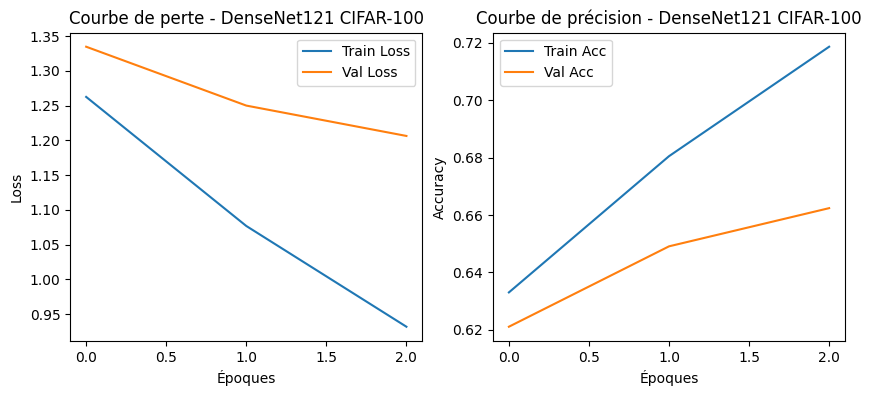

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Courbe de perte - DenseNet121 CIFAR-100")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Courbe de précision - DenseNet121 CIFAR-100")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### Matrice de confusion et de perte

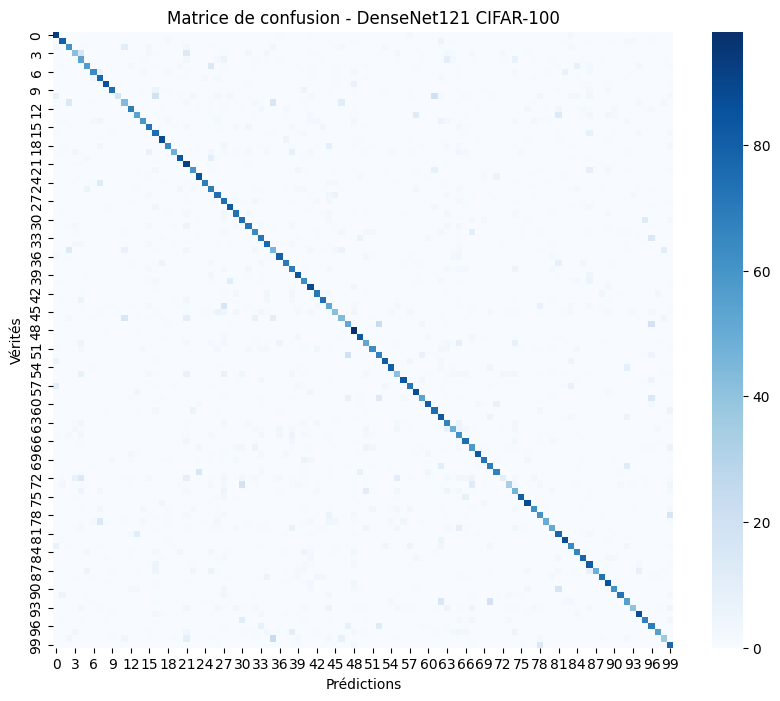


Rapport de classification DenseNet121 CIFAR-100
               precision    recall  f1-score   support

        apple       0.71      0.93      0.81       100
aquarium_fish       0.82      0.80      0.81       100
         baby       0.61      0.61      0.61       100
         bear       0.55      0.42      0.48       100
       beaver       0.38      0.54      0.45       100
          bed       0.74      0.57      0.64       100
          bee       0.78      0.64      0.70       100
       beetle       0.59      0.78      0.67       100
      bicycle       0.91      0.86      0.89       100
       bottle       0.89      0.75      0.82       100
         bowl       0.94      0.17      0.29       100
          boy       0.52      0.44      0.48       100
       bridge       0.78      0.69      0.73       100
          bus       0.67      0.54      0.60       100
    butterfly       0.82      0.59      0.69       100
        camel       0.67      0.72      0.69       100
          can  

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Matrice de confusion - DenseNet121 CIFAR-100")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

print("\nRapport de classification DenseNet121 CIFAR-100")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))

#### EfficientNetB0

##### Définition du modèle

In [ ]:
class CNN_EfficientNetB0(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN_EfficientNetB0, self).__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_EfficientNetB0(num_classes=100).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 166MB/s]


##### Optimiseur

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Entraînement du modèle

In [ ]:
num_epochs = 3
train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_train = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss /= total_val
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Époque [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

end_train = time.time()
train_time = end_train - start_train
print(f"\nTemps total d'entraînement EfficientNetB0 CIFAR-100 : {train_time:.2f} secondes")


Époque [1/3] - Train Loss: 1.9854, Train Acc: 0.4684, Val Acc: 0.6301
Époque [2/3] - Train Loss: 1.2894, Train Acc: 0.6314, Val Acc: 0.6570
Époque [3/3] - Train Loss: 1.0369, Train Acc: 0.6968, Val Acc: 0.6811

Temps total d'entraînement EfficientNetB0 CIFAR-100 : 813.89 secondes


##### Evaluation sur le test

In [ ]:
start_test = time.time()
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= total_test
test_acc = correct_test / total_test
end_test = time.time()
test_duration = end_test - start_test

print(f"\nTest accuracy EfficientNetB0 CIFAR-100: {test_acc:.4f}, test loss: {test_loss:.4f}")
print(f"Temps de test EfficientNetB0 CIFAR-100 : {test_duration:.2f} secondes")


Test accuracy EfficientNetB0 CIFAR-100: 0.6856, test loss: 1.1195
Temps de test EfficientNetB0 CIFAR-100 : 25.02 secondes


##### Courbes d'entraînement et de perte

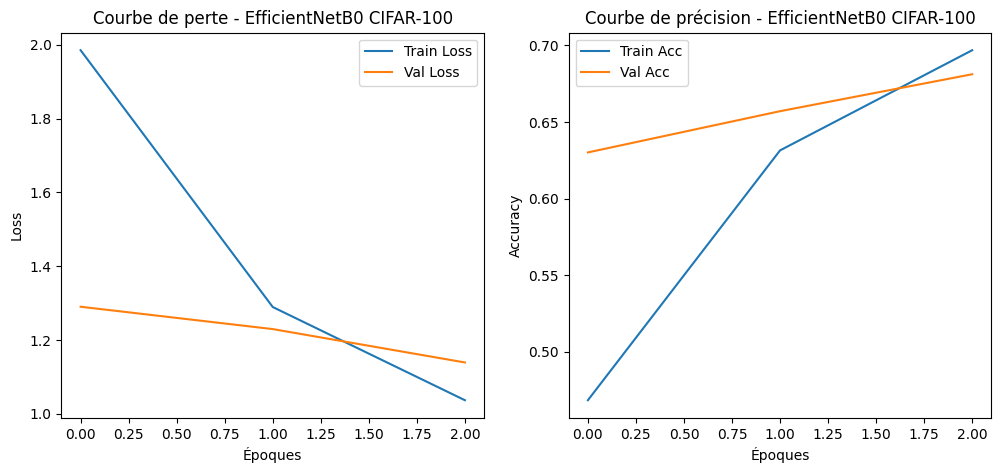

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Courbe de perte - EfficientNetB0 CIFAR-100")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Courbe de précision - EfficientNetB0 CIFAR-100")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### Matrice de confusion et rapport de classification

In [ ]:
print("\nRapport de classification EfficientNetB0 (CIFAR-100)")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))


Rapport de classification EfficientNetB0 (CIFAR-100)
               precision    recall  f1-score   support

        apple       0.93      0.75      0.83       100
aquarium_fish       0.71      0.87      0.78       100
         baby       0.50      0.69      0.58       100
         bear       0.41      0.65      0.50       100
       beaver       0.59      0.42      0.49       100
          bed       0.82      0.54      0.65       100
          bee       0.80      0.65      0.72       100
       beetle       0.90      0.66      0.76       100
      bicycle       0.75      0.92      0.83       100
       bottle       0.86      0.87      0.87       100
         bowl       0.48      0.60      0.53       100
          boy       0.30      0.77      0.43       100
       bridge       0.84      0.64      0.73       100
          bus       0.78      0.35      0.48       100
    butterfly       0.87      0.72      0.79       100
        camel       0.60      0.81      0.69       100
          

### **Comparaison des modèles CNN sur CIFAR-100**

| Modèle| Accuracy| Précision | Recall | Score F1 | Loss | Entraînement (s) | Test (s) |
| -- | -- | -- | -- | -- | -- | -- | -- |
| **VGG16**| 0.43 | 0.52 | 0.43 | 0.43 | 2.1367 | 2264.76 | 68.27|
| **DenseNet121**| 0.67 | 0.69 | 0.67 | 0.67 | 1.19 | 1540 | 52.6|
| **EfficientNetB0** | 0.69 | 0.71 | 0.69 | 0.69 | 1.11 | 813.89| 25.0|


* **VGG16** : Performance faible 43 %, modèle trop lourd et mal adapté à CIFAR-100.
* **DenseNet121** : Bon équilibre, 67 % de précision, temps raisonnable.
* **EfficientNetB0** : Meilleure performance 69 % et plus rapide.


* **Transfert learning** : améliore fortement les performances (DenseNet, EfficientNet).
* **Architecture** : plus moderne = meilleure propagation du gradient et moins de paramètres.
* **Coût/performance** : **EfficientNetB0** offre le meilleur rapport précision/vitesse.

### L’impact du Transfer Learning
- Les modèles pré-entraînés (VGG16, DenseNet121, EfficientNetB0) bénéficient de connaissances acquises sur ImageNet.
- Les architectures modernes (DenseNet, EfficientNet) exploitent mieux le transfert learning, améliorant nettement l’accuracy.
- VGG16, plus ancien et lourd, peine à généraliser sur CIFAR-100 malgré le transfert.

### Influence de l’architecture et de la complexité
- DenseNet121 : connexions denses pour réutilisation des features et meilleure propagation du gradient.
- EfficientNetB0 : architecture optimisée avec scaling équilibré, moins de paramètres et plus efficace.
- VGG16 : architecture très profonde, lourde, moins performante sur petits jeux de données.
